In [1]:
import kagglehub
awsaf49_brats20_dataset_training_validation_path = kagglehub.dataset_download('awsaf49/brats20-dataset-training-validation')

print('Data source import complete.')


Data source import complete.


Importing required libraries and modules.

In [2]:
# Suppress TensorFlow logs and select GPU
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress warnings
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Use first GPU

# Core Python
import random
import glob
import shutil
from pathlib import Path

# Data & Image processing
import numpy as np
import pandas as pd
import cv2
import nibabel as nib
from PIL import Image
from skimage.util import montage
from skimage.transform import resize, rotate

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# ML utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

# TensorFlow / Keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate,
    Dropout, BatchNormalization, Activation
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, ReduceLROnPlateau, EarlyStopping,
    TensorBoard, CSVLogger
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanIoU

# Configure GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(f"GPU config error: {e}")

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Confirm setup
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {gpus}")
print(f"Using GPU: {len(gpus) > 0}")

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU: True


Iterating thorugh the training data directory and finding missing files.

In [3]:
TRAIN_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
folders = os.listdir(TRAIN_DATASET_PATH)

required_suffixes = ['_t1.nii', '_t1ce.nii', '_t2.nii', '_flair.nii', '_seg.nii']
missing_files = []

for folder in folders:
    folder_path = os.path.join(TRAIN_DATASET_PATH, folder)
    if not os.path.isdir(folder_path):
        continue
    files = os.listdir(folder_path)

    for suffix in required_suffixes:
        expected_file = folder + suffix
        if expected_file not in files:
            missing_files.append((folder, expected_file))

if len(missing_files) == 0:
    print("All files present in folders")
else:
    print("Missing files detected!")
    for entry in missing_files:
        print(f"No {entry[1]} for file {entry[0]}")

Missing files detected!
No BraTS20_Training_355_seg.nii for file BraTS20_Training_355


In [4]:
old_name = TRAIN_DATASET_PATH + "W39_1998.09.19_Segm.nii"
new_name = TRAIN_DATASET_PATH + "BraTS20_Training_355_seg.nii"

try:
    os.rename(old_name, new_name)
    print("File re-named successfully!")
except Exception as e:
    print(f"Error renaming file : {e}")

Error renaming file : [Errno 30] Read-only file system: '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/W39_1998.09.19_Segm.nii' -> '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355_seg.nii'


Removed this file from the dataset before training, as it is not getting renamed and to avoid confusion later on.

Analysing the shape, dtype, min and max values in the .nii files.

In [5]:
test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Shape:  (240, 240, 155)
Dtype:  float64
Min:  0.0
Max:  1854.603271484375


Normalize voxel intensity values of the .nii files so that they lie within the range [0, 1] using MinMaxScaler.

In [6]:
scaler = MinMaxScaler()
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1.0


Loading the T1, T1ce, T2, Flair and the segmentation mask and visualizing a particular slice.

In [7]:
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/W39_1998.09.19_Segm.nii').get_fdata()

Slice Number: 95


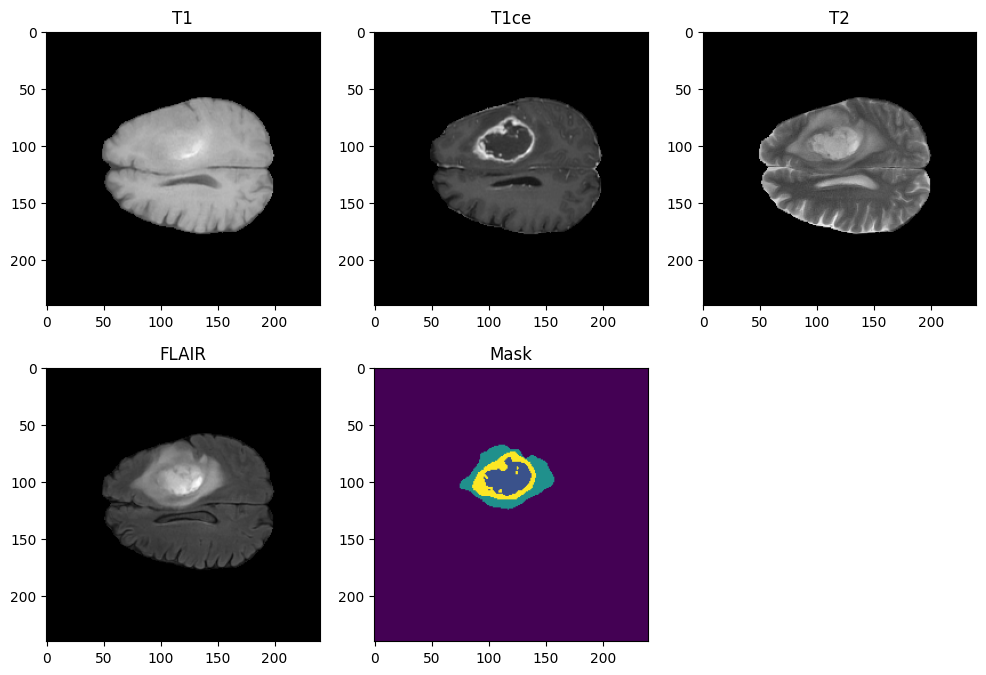

In [8]:
slice = 95
print("Slice Number: " + str(slice))

plt.figure(figsize = (12, 8))

plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:, :, slice], cmap='gray')
plt.title('T1')

plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:, :, slice], cmap='gray')
plt.title('T1ce')

plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:, :, slice], cmap='gray')
plt.title('T2')

plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:, :, slice], cmap='gray')
plt.title('FLAIR')

plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:, :, slice])
plt.title('Mask')

plt.show()

Analysing the shape of the modality and the segmentation mask.

In [9]:
print("Modality shape: ", test_image_t1.shape)
print("Segmentation shape: ", test_image_seg.shape)

Modality shape:  (240, 240, 155)
Segmentation shape:  (240, 240, 155)


Visualizing the transverse (axial), frontal (coronal), and sagittal (lateral) views of the 3D MRI volume.

Slice number: 95


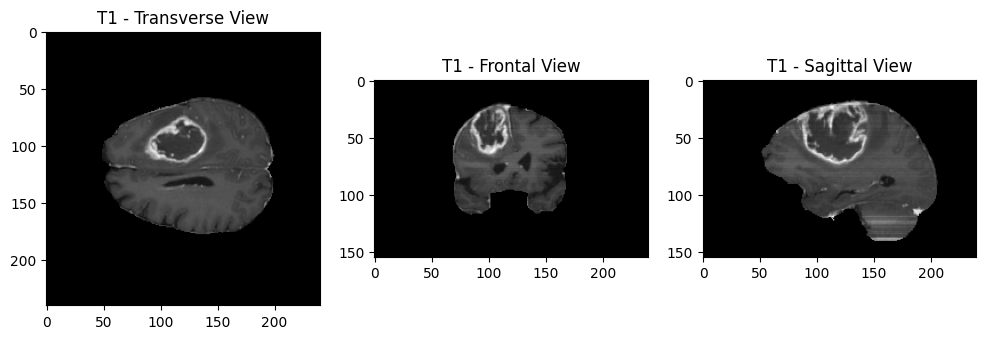

In [10]:
print(f"Slice number: {slice}")

plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:, :, slice], cmap='gray')
plt.title('T1 - Transverse View')

plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:, slice, :], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')

plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice, :, :], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

Plotting 2D slices along a chosen axis of 3D t1ce scans by arranging them into a tiled 2D grid using montage.

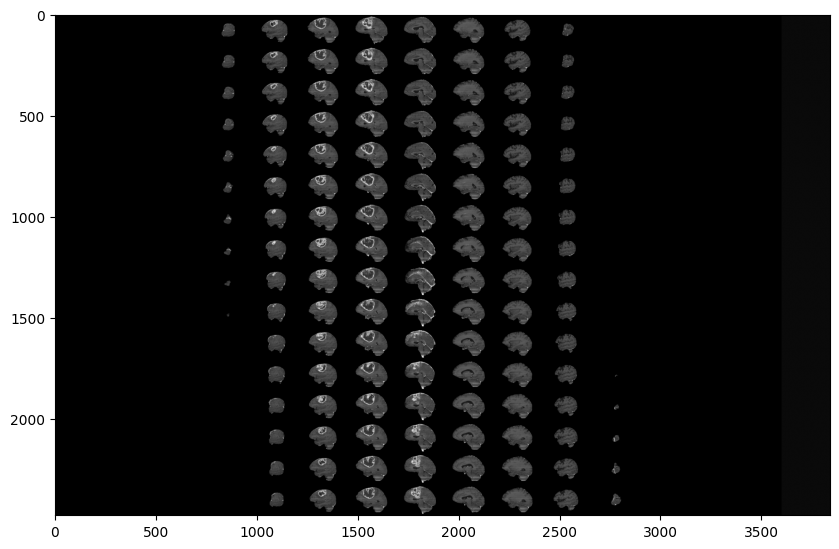

In [11]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

plt.imshow(rotate(montage(test_image_t1ce[:, :, :]), 90, resize=True), cmap='gray')
plt.show()

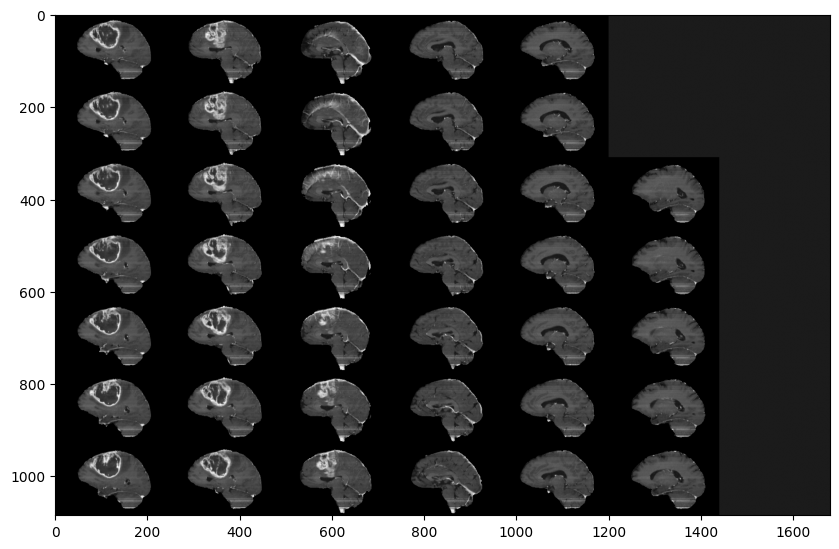

In [12]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_t1ce[100:-100, :, :]), 90, resize=True), cmap='gray')
plt.show()

Similarly, plotting 2D slices along a chosen axis of 3D segmentations by arranging them into a tiled 2D grid using montage.

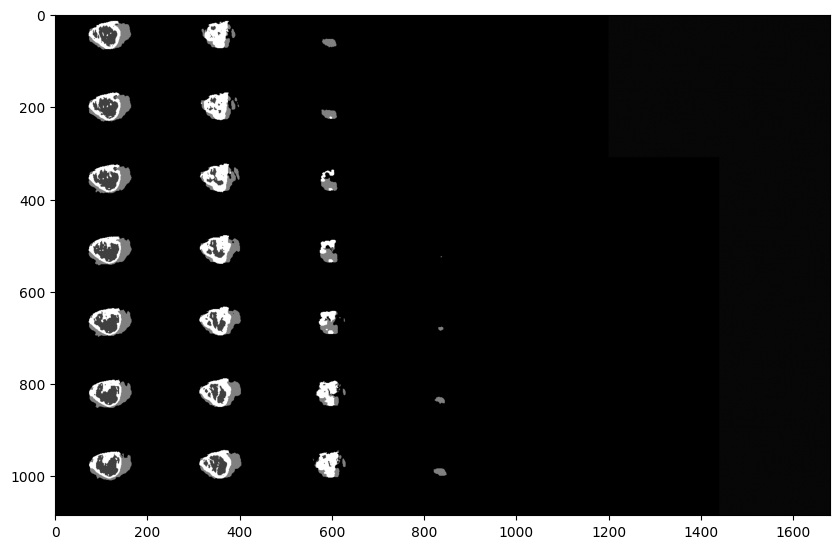

In [13]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_seg[100:-100, :, :]), 90, resize=True), cmap='gray')
plt.show()

This code visualizes a 2D slice of the segmentation mask using a custom colormap, mapping label values 0–3 to distinct colors via BoundaryNorm.

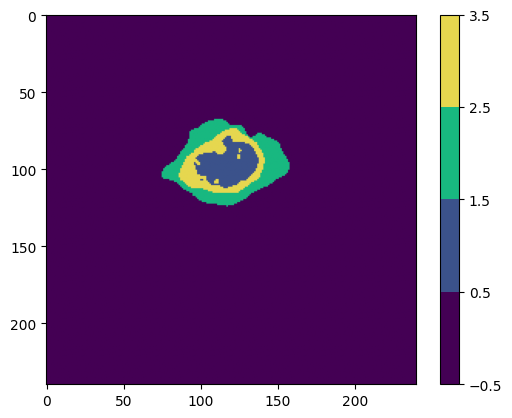

In [14]:
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(test_image_seg[:, :, 95], cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

This code isolates and visualizes each segmentation class (0, 1, 2, 4) in a selected MRI slice using a custom color map, allowing for side-by-side comparison of individual tumor components.

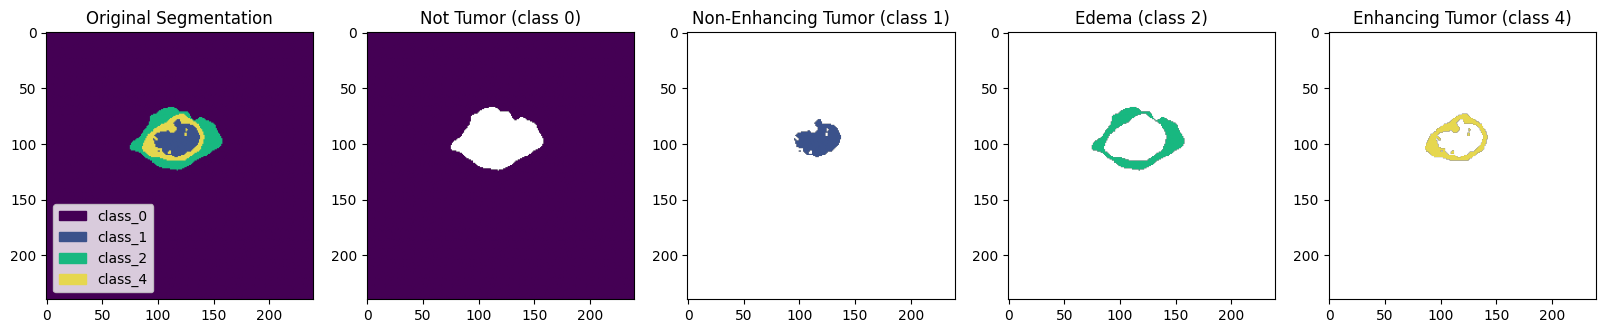

In [15]:
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

class_names = ['class_0', 'class_1', 'class_2', 'class_4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg[:, :, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

ax[1].imshow(seg_0[:, :, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

ax[2].imshow(seg_1[:, :, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')

ax[3].imshow(seg_2[:, :, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')

ax[4].imshow(seg_4[:, :, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.show()

Defining the train, validation, and test sets by listing all the required folders, removing a known bad sample, and splitting the dataset into train, val, and test set.

In [16]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def path_list_into_IDs(dir_list):
    x = []
    for i in range(0, len(dir_list)):
        x.append(dir_list[i][dir_list[i].rfind('/')+1:])
    return x

train_and_test_ids = path_list_into_IDs(train_and_val_directories)
train_and_test_ids.remove('BraTS20_Training_355')
print('BraTS20_Training_355' in train_and_test_ids)

train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)

print(f"Train Length: {len(train_ids)}")
print(f"Validation Length: {len(val_ids)}")
print(f"Test Length: {len(test_ids)}")

False
Train Length: 249
Validation Length: 74
Test Length: 45


Visualizing the bar chart showing the number of images in the training, validation, and test sets using different colors and labels for each.

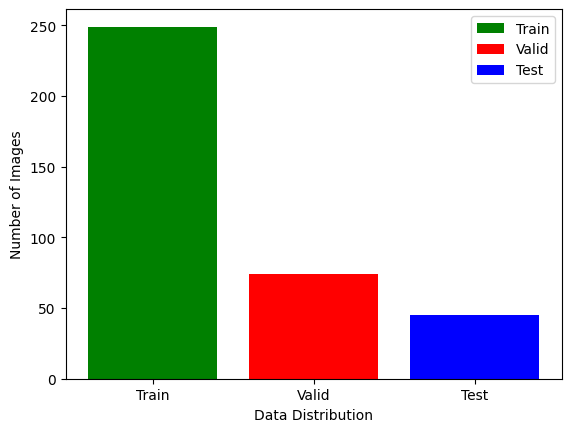

In [17]:
plt.bar(["Train", "Valid", "Test"], [len(train_ids), len(val_ids), len(test_ids)],
       align='center',
       color=['green', 'red', 'blue'],
       label=['Train', 'Valid', 'Test'])

plt.legend()
plt.ylabel('Number of Images')
plt.xlabel('Data Distribution')
plt.show()

Defines class label mappings for tumor segmentation and sets constants for image preprocessing and volume slicing before training the U-Net model.

In [18]:
SEGMENT_CLASSES = {
    0 : 'NOT TUMOR',
    1 : 'NECROTIC/CORE',
    2 : 'EDEMA',
    3 : 'ENHANCING'
}

VOLUME_SLICES = 100
VOLUME_START_AT = 22
IMG_SIZE = 128

For training, evaluation, and testing, we use only the FLAIR and T1ce modalities, as they are the most informative for brain tumor segmentation. This choice also helps simplify the model and reduce computational overhead, which is important given our limited hardware resources.

Custom Keras data generator that loads, preprocesses, and batches 2D MRI slices (Flair & T1ce) and segmentation masks from 3D volumes for U-Net training.

In [19]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, dim = (IMG_SIZE, IMG_SIZE), batch_size = 1, n_channels = 2, shuffle = True, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.list_IDs)/self.batch_size))

    def __getitem__(self, index):
        # Generate indexes for this batch
        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(batch_ids)
        return X, Y

    def on_epoch_end(self):
        # Updates indexes after each epoch for shuffling
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240), dtype=np.uint8)

        for c, i in enumerate(batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            flair = nib.load(os.path.join(case_path, f'{i}_flair.nii')).get_fdata()
            t1ce = nib.load(os.path.join(case_path, f'{i}_t1ce.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{i}_seg.nii')).get_fdata()

            # Normalize flair and t1ce per volume (min-max)
            flair = (flair - flair.min()) / (flair.max() - flair.min() + 1e-8)
            t1ce = (t1ce - t1ce.min()) / (t1ce.max() - t1ce.min() + 1e-8)

            for j in range(VOLUME_SLICES):
                slice_idx = j + VOLUME_START_AT

                X[c * VOLUME_SLICES + j, :, :, 0] = cv2.resize(flair[:, :, slice_idx], self.dim, interpolation=cv2.INTER_LINEAR)
                X[c * VOLUME_SLICES + j, :, :, 1] = cv2.resize(t1ce[:, :, slice_idx], self.dim, interpolation=cv2.INTER_LINEAR)
                y[c * VOLUME_SLICES + j, :, :] = seg[:, :, slice_idx]

        # Remap class 4 to 3
        y[y == 4] = 3

        # One-hot encode
        mask = tf.one_hot(y, depth=4)

        # Resize masks using nearest neighbor to preserve labels
        Y = tf.image.resize(mask, self.dim, method='nearest')

        return X, Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

Extracting and visualizing a specific 2D MRI slice and its corresponding segmentation from a batch generated by the custom DataGenerator.


[DATA GENERATOR INFO]
Batch size (volumes per batch): 1
Image dimension: (128, 128)
Channels: 2
VOLUME_SLICES used per volume: 100
Total samples in this batch: 100

[INPUT BATCH SHAPE]
X_batch shape: (100, 128, 128, 2)  # (slices, H, W, channels)
Y_batch shape: (100, 128, 128, 4)  # (slices, H, W, classes)

[SINGLE SLICE SHAPE]
Flair slice shape: (128, 128)
T1ce slice shape: (128, 128)
Segmentation slice shape: (128, 128)


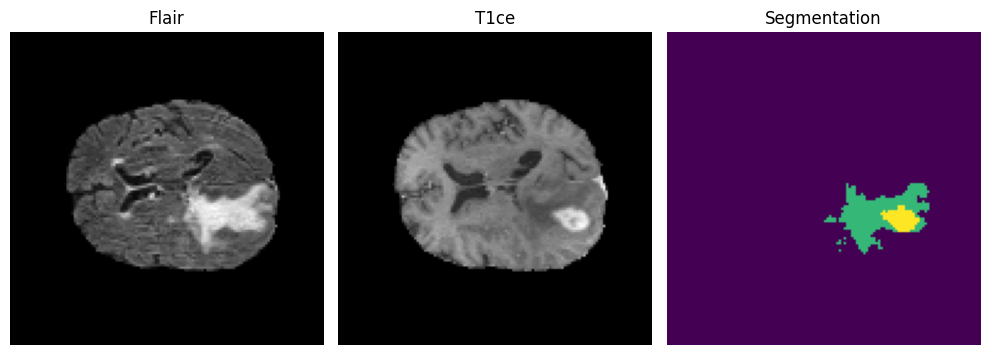

In [20]:
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1ce')
    axes[1].axis('off')

    axes[2].imshow(segmentation)
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

index_to_check = 10
X_batch, Y_batch = training_generator[index_to_check]

# Data Generator Settings
print(f"\n[DATA GENERATOR INFO]")
print(f"Batch size (volumes per batch): {training_generator.batch_size}")
print(f"Image dimension: {training_generator.dim}")
print(f"Channels: {training_generator.n_channels}")
print(f"VOLUME_SLICES used per volume: {VOLUME_SLICES}")
print(f"Total samples in this batch: {X_batch.shape[0]}")

# Input image stats
print(f"\n[INPUT BATCH SHAPE]")
print(f"X_batch shape: {X_batch.shape}  # (slices, H, W, channels)")
print(f"Y_batch shape: {Y_batch.shape}  # (slices, H, W, classes)")

flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]
segmentation_batch = np.argmax(Y_batch, axis=-1)

# Inspect one slice
slice_index = 60
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

print(f"\n[SINGLE SLICE SHAPE]")
print(f"Flair slice shape: {slice_flair.shape}")
print(f"T1ce slice shape: {slice_t1ce.shape}")
print(f"Segmentation slice shape: {slice_segmentation.shape}")

display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)

Defines Dice coefficient metrics for evaluating overall and class-wise segmentation performance across four tumor classes.

In [21]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = tf.reshape(y_true[:, :, :, i], [-1])
        y_pred_f = tf.reshape(y_pred[:, :, :, i], [-1])

        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss

    total_loss = total_loss / class_num
    return total_loss

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 1] * y_pred[:, :, :, 1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 1])) + K.sum(K.square(y_pred[:, :, :, 1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 2] * y_pred[:, :, :, 2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 2])) + K.sum(K.square(y_pred[:, :, :, 2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 3] * y_pred[:, :, :, 3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 3])) + K.sum(K.square(y_pred[:, :, :, 3])) + epsilon)

Defines custom Keras metrics to compute precision, sensitivity (recall), and specificity for model evaluation.

In [22]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

Function for building a U-Net model for multi-class image segmentation using an encoder-decoder architecture with skip connections, convolutional layers, and a softmax output for 4 classes.

In [23]:
def build_unet(inputs, ker_init, dropout):
    #Encoder Block 1
    enc1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    enc1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(enc1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(enc1)

    #Encoder Block 2
    enc2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    enc2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(enc2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(enc2)

    #Encoder Block 3
    enc3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    enc3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(enc3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(enc3)

    #Encoder Block 4
    enc4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
    enc4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(enc4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(enc4)

    #Bottleneck
    bottleneck = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    bottleneck = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(bottleneck)
    bottleneck = Dropout(dropout)(bottleneck)

    #Decoder Block 1
    up1 = UpSampling2D(size=(2, 2))(bottleneck)
    up1 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(up1)
    merge1 = concatenate([enc4, up1], axis=3)
    dec1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge1)
    dec1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(dec1)

    #Decoder Block 2
    up2 = UpSampling2D(size=(2, 2))(dec1)
    up2 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(up2)
    merge2 = concatenate([enc3, up2], axis=3)
    dec2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge2)
    dec2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(dec2)

    #Decoder Block 3
    up3 = UpSampling2D(size=(2, 2))(dec2)
    up3 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(up3)
    merge3 = concatenate([enc2, up3], axis=3)
    dec3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge3)
    dec3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(dec3)

    #Decoder Block 4
    up4 = UpSampling2D(size=(2, 2))(dec3)
    up4 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(up4)
    merge4 = concatenate([enc1, up4], axis=3)
    dec4 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge4)
    dec4 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(dec4)

    #Output Layer: 4 classes for multi-class segmentation
    output = Conv2D(4, (1, 1), activation='softmax')(dec4)

    return Model(inputs=inputs, outputs=output)

This custom metric computes Mean IoU by converting both one-hot encoded y_true and softmax y_pred to class labels using argmax.

In [24]:
class MeanIoUArgMax(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

Code for building, compililing, and visualizing the U-Net model for 4-class image segmentation using softmax outputs, with the custom loss and metrics for performance evaluation.

In [25]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = [
                  'accuracy',
                  MeanIoUArgMax(num_classes=4),
                  dice_coef,
                  precision,
                  sensitivity,
                  specificity,
                  dice_coef_necrotic,
                  dice_coef_edema,
                  dice_coef_enhancing
              ]
             )

plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_names = True,
    rankdir = 'TB',
    expand_nested = False,
    dpi = 70
)

print(model.metrics_names)

['loss', 'compile_metrics']


Callbacks list which includes tools to reduce learning rate on validation loss plateau, saving the best model weights during training, and log training metrics to a CSV file for later analysis.

In [26]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.000001,
    verbose=1
    ),

    keras.callbacks.ModelCheckpoint(
    filepath='model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
    verbose=1,
    save_best_only=True,
    save_weights_only=True
    ),
    CSVLogger('/content/training.log', separator=',', append=False)
]

Suppressing TensorFlow log clutter and disabling XLA device optimizations to reduce log noise and avoid potential compatibility issues during model execution.

In [27]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

Code for clearing any previous TensorFlow models from memory (K.clear_session()) and then training the U-Net model using a data generator (training_generator) for 35 epochs with specified callbacks and validation data.

In [28]:
K.clear_session()

history = model.fit(training_generator,
                    epochs=35,
                    callbacks=callbacks,
                    validation_data=valid_generator,
                   )

Epoch 1/35
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.9816 - dice_coef: 0.2645 - dice_coef_edema: 0.1215 - dice_coef_enhancing: 0.0325 - dice_coef_necrotic: 0.0520 - loss: 0.1694 - mean_io_u_arg_max: 0.2475 - precision: 0.9849 - sensitivity: 0.9468 - specificity: 0.9951
Epoch 1: val_loss improved from inf to 0.06238, saving model to model_.01-0.062377.weights.h5
249/249 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.9816 - dice_coef: 0.2645 - dice_coef_edema: 0.1217 - dice_coef_enhancing: 0.0326 - dice_coef_necrotic: 0.0522 - loss: 0.1692 - mean_io_u_arg_max: 0.2475 - precision: 0.9849 - sensitivity: 0.9469 - specificity: 0.9951 - val_accuracy: 0.9844 - val_dice_coef: 0.2884 - val_dice_coef_edema: 0.2530 - val_dice_coef_enhancing: 0.0733 - val_dice_coef_necrotic: 0.0859 - val_loss: 0.0624 - val_mean_io_u_arg_max: 0.2462 - val_precision: 0.9845 - val_sensitivity: 0.9844 - val_specificity: 0.9948 - learning_rate: 0.0010
Epoch 2/35
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step

Saving the entire trained model (architecture, weights, and optimizer state) to the file /content/my_model.keras in the Keras native format.

In [29]:
model.save("/content/my_model.keras")

Loading the saved Keras model while registering custom metric functions needed for correct deserialization and skipping recompiling it immediately.

In [30]:
model = keras.models.load_model('/content/my_model.keras',
                         custom_objects={
                             "MeanIoUArgMax" : MeanIoUArgMax(num_classes=4),
                             "dice_coef" : dice_coef,
                             "precision" : precision,
                             "sensitivity" : sensitivity,
                             "specificity" : specificity,
                             "dice_coef_necrotic" : dice_coef_necrotic,
                             "dice_coef_edema" : dice_coef_edema,
                             "dice_coef_enhancing" : dice_coef_enhancing
                         },
                         compile=False)

Reading the training logs from the CSV file and plotting the training vs. validation accuracy, loss, Dice coefficient, and Mean IoU over epochs for visual performance analysis.

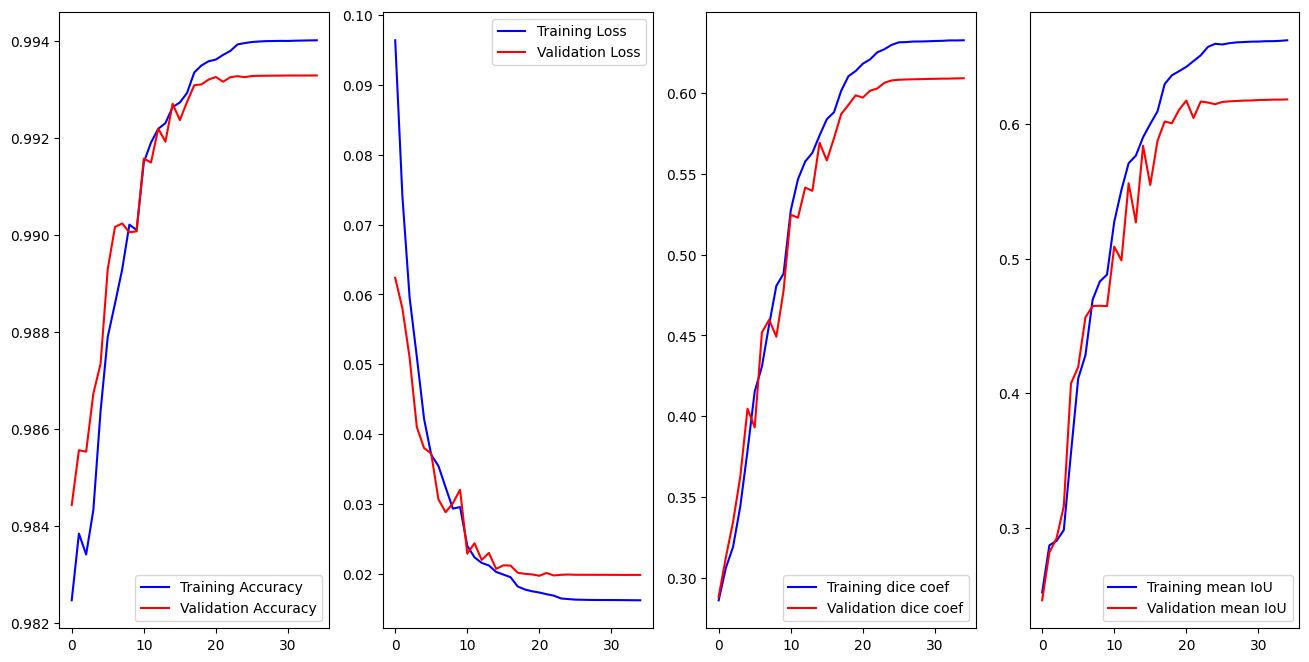

In [31]:
hist = pd.read_csv('/content/training.log', sep=',', engine='python')
acc = hist['accuracy']
val_acc = hist['val_accuracy']
epoch = range(len(acc))

loss = hist['loss']
val_loss = hist['val_loss']
train_dice = hist['dice_coef']
val_dice = hist['val_dice_coef']

f, ax = plt.subplots(1, 4, figsize=(16, 8))

ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch, loss, 'b', label='Training Loss')
ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch, train_dice, 'b', label='Training dice coef')
ax[2].plot(epoch, val_dice, 'r', label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch, hist['mean_io_u_arg_max'], 'b', label='Training mean IoU')
ax[3].plot(epoch, hist['val_mean_io_u_arg_max'], 'r', label='Validation mean IoU')
ax[3].legend()

plt.show()

Finding the best model file (lowest validation loss) from saved .weights.h5 files by extracting and comparing the val_loss embedded in their filenames.

In [32]:
import re

model_files = [f for f in os.listdir('.') if f.startswith('model_') and f.endswith('.weights.h5')]

def extract_val_loss(filename):
    match = re.search(r'model_\.(\d+)-([\d.]+)\.weights\.h5', filename)
    if match:
        epoch = int(match.group(1))
        val_loss = float(match.group(2))
        return epoch, val_loss
    return None, float('inf')  # If not matched, return high loss

model_files_with_loss = [(f, extract_val_loss(f)[1]) for f in model_files]
model_files_with_loss.sort(key=lambda x : x[1])  # Sort by val_loss

best_model_file = model_files_with_loss[0][0]
best_val_loss = model_files_with_loss[0][1]

print(f"Best model file: {best_model_file} (val_loss = {best_val_loss:.6f})")

Best model file: model_.21-0.019735.weights.h5 (val_loss = 0.019735)


This code rebuilds and compiles the U-Net model, then loads the weights from the saved model file with the lowest validation loss for further evaluation or inference.

In [33]:
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

best_saved_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        metrics=['accuracy',
                                MeanIoU(num_classes=4),
                                dice_coef,
                                precision,
                                sensitivity,
                                specificity,
                                dice_coef_necrotic,
                                dice_coef_edema,
                                dice_coef_enhancing])

best_saved_model.load_weights(f'{best_model_file}')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


This code evaluates the best saved U-Net model on the test dataset using the test_generator, printing both the names of the metrics and their corresponding values.

In [34]:
results = best_saved_model.evaluate(test_generator, verbose=1)
print(best_saved_model.metrics_names)
print(results)

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 775ms/step - accuracy: 0.9914 - dice_coef: 0.5693 - dice_coef_edema: 0.6328 - dice_coef_enhancing: 0.5698 - dice_coef_necrotic: 0.5180 - loss: 0.0257 - mean_io_u: 0.8239 - precision: 0.9930 - sensitivity: 0.9902 - specificity: 0.9977
['loss', 'compile_metrics']
[0.02552979066967964, 0.9910354018211365, 0.8291091918945312, 0.574756383895874, 0.9926310181617737, 0.9897951483726501, 0.9975539445877075, 0.5085791945457458, 0.6488596200942993, 0.5695561170578003]


Printing the results in a formatted way for easy interpretation of model performance across all metrics.

In [35]:
descriptions = [
    "Loss",
    "Accuracy",
    "Mean IoU",
    "Dice coefficient",
    "Precision",
    "Sensitivity",
    "Specificity",
    "Dice coef Necrotic",
    "Dice coef Edema",
    "Dice coef Enhancing"
]

for metric, description in zip(results, descriptions):
    print(f"{description} : {metric:.4f}")

Loss : 0.0255
Accuracy : 0.9910
Mean IoU : 0.8291
Dice coefficient : 0.5748
Precision : 0.9926
Sensitivity : 0.9898
Specificity : 0.9976
Dice coef Necrotic : 0.5086
Dice coef Edema : 0.6489
Dice coef Enhancing : 0.5696


Visualizing a single MRI slice from the training data by displaying the Flair and T1ce modalities, the ground truth segmentation, and the predicted segmentation from the model side by side for qualitative comparison.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction raw shape:  (100, 128, 128, 4)
Prediction label shape:  (100, 128, 128)


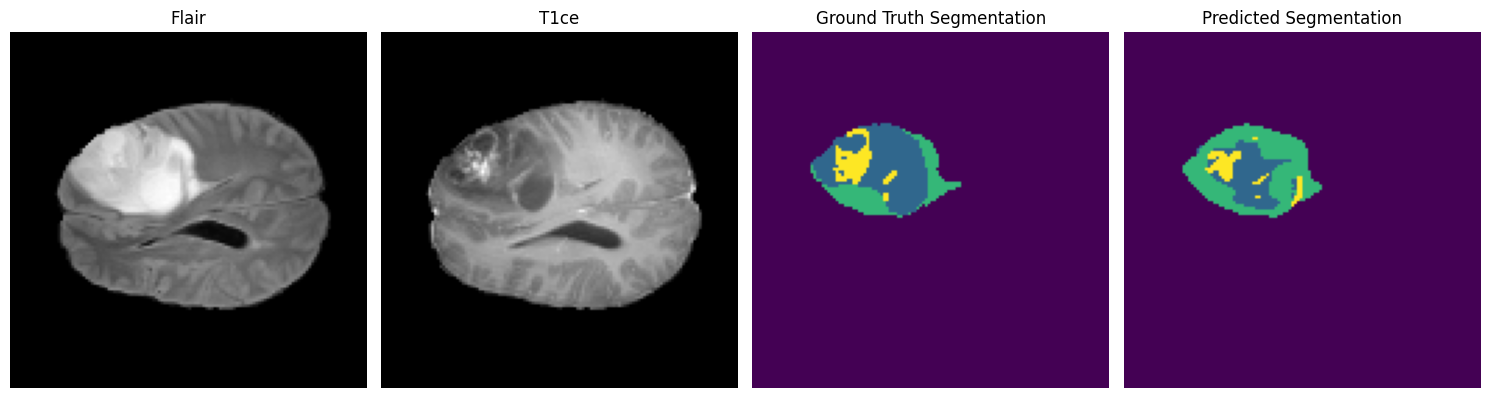

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def display_slice_with_groundtruth_and_prediction(flair, t1ce, ground_truth, prediction):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1ce')
    axes[1].axis('off')

    axes[2].imshow(ground_truth)
    axes[2].set_title('Ground Truth Segmentation')
    axes[2].axis('off')

    axes[3].imshow(prediction)
    axes[3].set_title('Predicted Segmentation')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

# Picking a batch from the TEST set
index_to_check = random.randint(1, 45)
X_test_batch, Y_test_batch = test_generator[index_to_check]

# Selecting a slice index from the 2D slices within the batch
slice_index = 60

# Extracting Flair and T1ce channels
flair_batch = X_test_batch[:, :, :, 0]
t1ce_batch = X_test_batch[:, :, :, 1]
ground_truth_batch = np.argmax(Y_test_batch, axis=-1)

# Selecting one slice
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_ground_truth = ground_truth_batch[slice_index]

# Predicting on the full batch
pred_batch = best_saved_model.predict(X_test_batch)
print("Prediction raw shape: ", pred_batch.shape)

# Converting predicted probabilities to class labels
pred_batch_labels = np.argmax(pred_batch, axis=-1)
print("Prediction label shape: ", pred_batch_labels.shape)

# Selecting the corresponding predicted slice
slice_prediction = pred_batch_labels[slice_index]

# Displaying flair, t1ce, ground truth, prediction
display_slice_with_groundtruth_and_prediction(
    slice_flair, slice_t1ce, slice_ground_truth, slice_prediction
)